Shape: (4803, 4)

Missing values:
 movie_id    0
title       0
cast        0
crew        0
dtype: int64

Top 5 like 'Avatar': ['Aliens', 'Snow White: A Tale of Terror', 'Guardians of the Galaxy', 'The Cold Light of Day', 'Man on a Ledge']


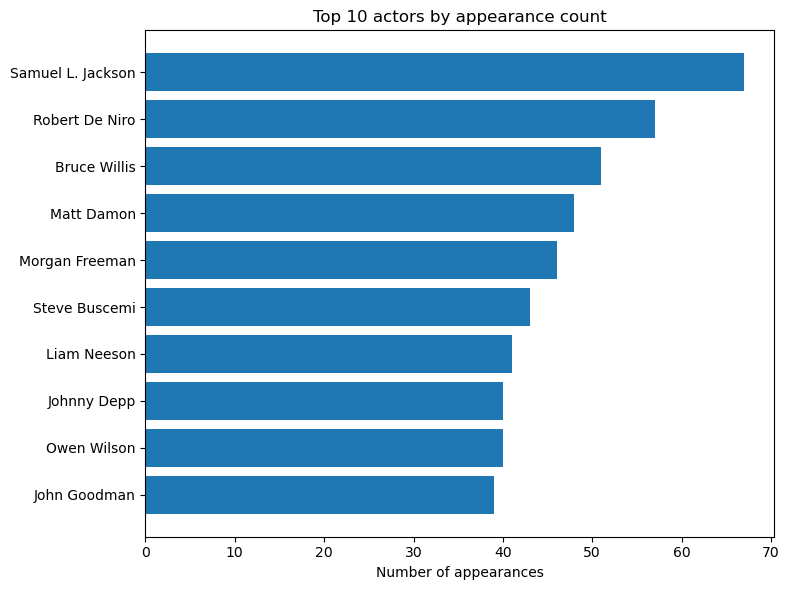

In [5]:
import pandas as pd, ast
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("tmdb_5000_credits.csv")

# Basic info
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())

# Helper functions
def cast_names(x, n=3):
    try:
        return " ".join([i["name"] for i in ast.literal_eval(x)][:n])
    except:
        return ""

def director_name(x):
    try:
        for i in ast.literal_eval(x):
            if i.get("job") == "Director":
                return i.get("name", "")
    except:
        return ""
    return ""

# Feature engineering
df["cast_names"] = df["cast"].fillna("[]").apply(cast_names)
df["director_name"] = df["crew"].fillna("[]").apply(director_name)
df["tags"] = (df["cast_names"] + " " + df["director_name"]).str.lower()

# Vectorization
cv = CountVectorizer(max_features=5000, stop_words="english")
vectors = cv.fit_transform(df["tags"])

# Recommender
def recommend(title, k=5):
    if title not in df["title"].values:
        return []
    idx = df[df["title"] == title].index[0]
    sims = cosine_similarity(vectors[idx], vectors).flatten()
    idxs = sims.argsort()[-(k+1):][::-1][1:]
    return df.iloc[idxs]["title"].tolist()

# Demonstration
print("\nTop 5 like 'Avatar':", recommend("Avatar"))

# Top‑10 actors
actors = []
for x in df["cast"]:
    try:
        actors.extend([i["name"] for i in ast.literal_eval(x)])
    except:
        pass
top10 = Counter(actors).most_common(10)
actors_names = [a for a, _ in top10]
counts = [c for _, c in top10]

plt.figure(figsize=(8,6))
plt.barh(actors_names[::-1], counts[::-1])
plt.title("Top 10 actors by appearance count")
plt.xlabel("Number of appearances")
plt.tight_layout()
plt.show()


In [8]:
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())

def cast_names(x, n=3):
    try:
        return " ".join([i["name"] for i in ast.literal_eval(x)][:n])
    except:
        return ""

def director_name(x):
    try:
        for i in ast.literal_eval(x):
            if i.get("job") == "Director":
                return i.get("name", "")
    except:
        return ""
    return ""

df["cast_names"] = df["cast"].fillna("[]").apply(cast_names)
df["director_name"] = df["crew"].fillna("[]").apply(director_name)
df["tags"] = (df["cast_names"] + " " + df["director_name"]).str.lower()

cv = CountVectorizer(max_features=2000, stop_words="english")
vectors = cv.fit_transform(df["tags"])

def recommend(title, k=5):
    if title not in df["title"].values:
        return []
    idx = df[df["title"] == title].index[0]
    sims = cosine_similarity(vectors[idx], vectors).flatten()
    idxs = sims.argsort()[-(k+1):][::-1][1:]
    return df.iloc[idxs]["title"].tolist()

print("\nTop 5 recommendations like 'Avatar':")
print(recommend("Avatar"))

actors = []
for x in df["cast"]:
    try:
        actors.extend([i["name"] for i in ast.literal_eval(x)])
    except:
        pass
top10 = Counter(actors).most_common(10)
print("\nTop 10 actors by appearance count:")
for actor, count in top10:
    print(f"{actor}: {count}")

Dataset shape: (4803, 7)

Missing values:
 movie_id         0
title            0
cast             0
crew             0
cast_names       0
director_name    0
tags             0
dtype: int64

Top 5 recommendations like 'Avatar':
['Aliens', 'Snow White: A Tale of Terror', 'Crossroads', 'Guardians of the Galaxy', 'The Cold Light of Day']

Top 10 actors by appearance count:
Samuel L. Jackson: 67
Robert De Niro: 57
Bruce Willis: 51
Matt Damon: 48
Morgan Freeman: 46
Steve Buscemi: 43
Liam Neeson: 41
Johnny Depp: 40
Owen Wilson: 40
John Goodman: 39


In [10]:
def cast_names(x, n=3):
    try:
        return " ".join([i["name"] for i in ast.literal_eval(x)][:n])
    except:
        return ""
df["cast_names"] = df["cast"].fillna("[]").apply(cast_names)
print(df["cast_names"].head())


0    Sam Worthington Zoe Saldana Sigourney Weaver
1       Johnny Depp Orlando Bloom Keira Knightley
2        Daniel Craig Christoph Waltz Léa Seydoux
3        Christian Bale Michael Caine Gary Oldman
4      Taylor Kitsch Lynn Collins Samantha Morton
Name: cast_names, dtype: object


In [14]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

normalizer = Normalizer()
normalized_vectors = normalizer.fit_transform(vectors)


svd = TruncatedSVD(n_components=100, random_state=42)
reduced_vectors = svd.fit_transform(normalized_vectors)


kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(reduced_vectors)
df['cluster'] = kmeans.labels_

cluster_counts = df['cluster'].value_counts().sort_index()
cluster_counts

cluster
0     207
1     116
2     109
3     361
4    3069
5     238
6     207
7     296
8      67
9     133
Name: count, dtype: int64

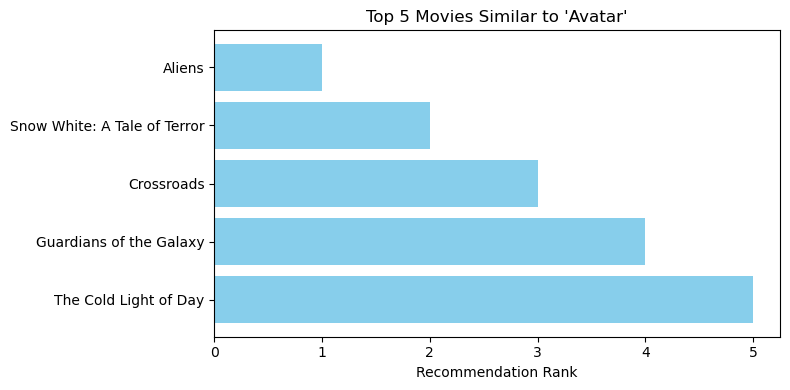

In [16]:
movie_title = "Avatar"
recommended_titles = recommend(movie_title)

plt.figure(figsize=(8, 4))
plt.barh(recommended_titles[::-1], range(1, 6)[::-1], color='skyblue')
plt.xlabel("Recommendation Rank")
plt.title(f"Top 5 Movies Similar to '{movie_title}'")
plt.tight_layout()
plt.show()

In [21]:
all_recs = []
for title in df["title"].unique():
    recs = recommend(title)
    all_recs.extend(recs)

rec_counter = Counter(all_recs)

# Most recommended movies (top 10)
most_recommended = rec_counter.most_common(10)
print("🔝 Most Recommended Movies:")
for title, count in most_recommended:
    print(f"{title}: {count}")

# Least recommended (at least once, bottom 10)
least_recommended = [item for item in rec_counter.items() if item[1] == 1][:10]
print("\n🔻 Least Recommended Movies (only once):")
for title, count in least_recommended:
    print(f"{title}: {count}")

🔝 Most Recommended Movies:
The Beyond: 185
Iraq for Sale: The War Profiteers: 114
She Wore a Yellow Ribbon: 113
Summer Storm: 112
You Got Served: 105
The Case of the Grinning Cat: 103
Barney's Great Adventure: 94
Ramanujan: 89
Drag Me to Hell: 72
The Age of Adaline: 70

🔻 Least Recommended Movies (only once):
The Amazing Spider-Man 2: 1
Spectre: 1
Hercules: 1
Sabotage: 1
Our Kind of Traitor: 1
Driving Lessons: 1
The Legend of Tarzan: 1
Free Birds: 1
Beowulf: 1
The Spirit: 1


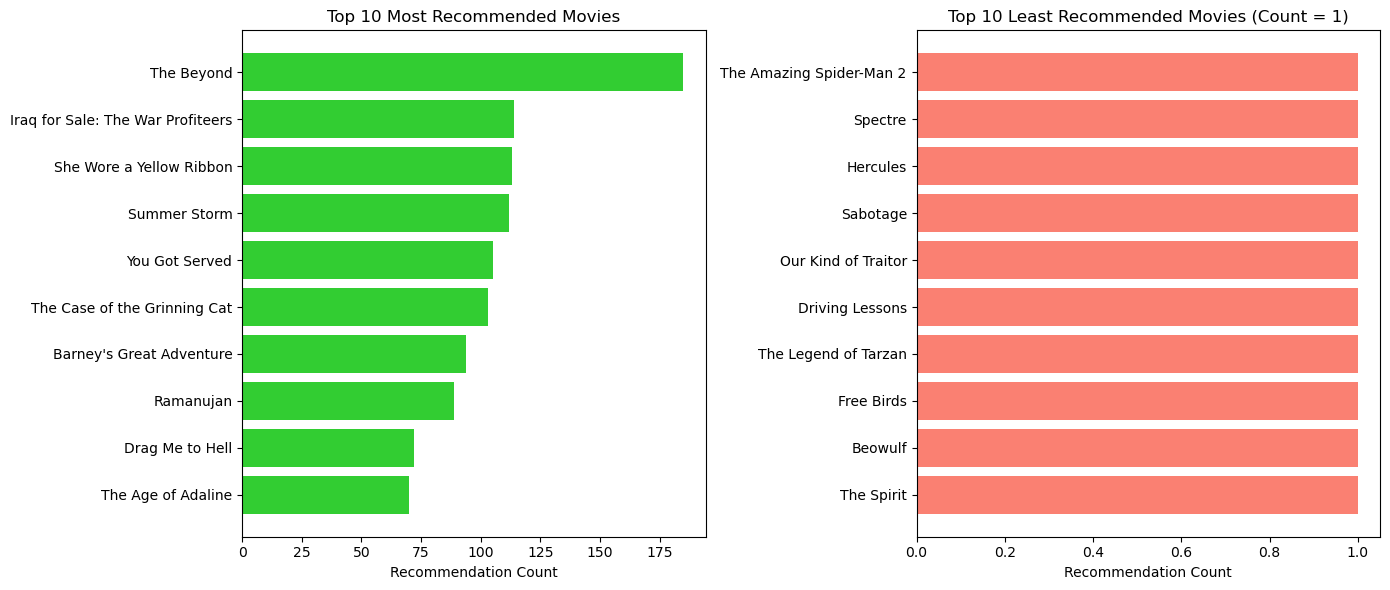

In [24]:
all_recs = []

for title in df["title"].unique():
    recs = recommend(title)
    all_recs.extend(recs)

rec_counter = Counter(all_recs)

# Top 10 most recommended
most_recommended = rec_counter.most_common(10)
most_titles = [title for title, _ in most_recommended]
most_counts = [count for _, count in most_recommended]

# Least recommended (count = 1, limit to 10 for chart)
least_recommended = [item for item in rec_counter.items() if item[1] == 1][:10]
least_titles = [title for title, _ in least_recommended]
least_counts = [1] * len(least_titles)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Most recommended
axes[0].barh(most_titles[::-1], most_counts[::-1], color="limegreen")
axes[0].set_title("Top 10 Most Recommended Movies")
axes[0].set_xlabel("Recommendation Count")

# Least recommended
axes[1].barh(least_titles[::-1], least_counts[::-1], color="salmon")
axes[1].set_title("Top 10 Least Recommended Movies (Count = 1)")
axes[1].set_xlabel("Recommendation Count")

plt.tight_layout()
plt.show()